In [15]:
# export
!pip install tsai
from torch.nn.utils import weight_norm
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TCN IMPLEMENTATION

# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Bai, S., Kolter, J. Z., & Koltun, V. (2018). An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271.
# Official TCN PyTorch implementation: https://github.com/locuslab/TCN


class TemporalBlock(Module):
    def __init__(self, ni, nf, ks, stride, dilation, padding, dropout=0.):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(ni,nf,ks,stride=stride,padding=padding,dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv1d(nf,nf,ks,stride=stride,padding=padding,dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, 
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(ni,nf,1) if ni != nf else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None: self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

def TemporalConvNet(c_in, layers, ks=2, dropout=0.):
    temp_layers = []
    for i in range(len(layers)):
        dilation_size = 2 ** i
        ni = c_in if i == 0 else layers[i-1]
        nf = layers[i]
        temp_layers += [TemporalBlock(ni, nf, ks, stride=1, dilation=dilation_size, padding=(ks-1) * dilation_size, dropout=dropout)]
    return nn.Sequential(*temp_layers)

class TCN(Module):
    def __init__(self, c_in, c_out, layers=8*[25], ks=7, conv_dropout=0., fc_dropout=0.):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(c_in, layers, ks=ks, dropout=conv_dropout)
        self.gap = GAP1d()
        self.dropout = nn.Dropout(fc_dropout) if fc_dropout else None
        self.linear = nn.Linear(layers[-1],c_out)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = self.tcn(x)
        x = self.gap(x)
        if self.dropout is not None: x = self.dropout(x)
        return self.linear(x)

In [19]:
class VolForecastModule(nn.Module):
    def __init__(self, input_dim):
        super(VolForecastModule, self).__init__()
        self.input_dim = input_dim
        self.tcn = TCN(c_in=2, c_out=1, layers=8*[25], ks=7)
    
    def forward(self, x):
        return self.tcn(x)

In [20]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def get_data(file_name, input_dim):
    df = pd.read_csv(file_name)
    inputs = df_to_tensor(df[['PRICE', 'SIZE']])
    outputs = df_to_tensor(df[['vol']])
    
    inputs = torch.stack([inputs[i:-input_dim+i] for i in range(input_dim)], dim = 1).transpose(1,2)
    outputs = outputs[input_dim:]
    
    return inputs, outputs

In [21]:
def train(opts, inputs, outputs, model):
    loss_fn = nn.MSELoss()
    input_dim = model.input_dim
    batch_size = opts['batch_size']
    
    train_losses = []
    
    for epoch in range(opts['nepochs']):
        inputs_batch = inputs[epoch * batch_size:(epoch + 1) * batch_size]
        outputs_batch = outputs[epoch * batch_size:(epoch + 1) * batch_size]
        loss = loss_fn(model(inputs_batch), outputs_batch)
        loss.backward()
        
        print(f"Loss: {loss}")

In [28]:
input_dim=50
model=VolForecastModule(input_dim=input_dim)
inputs, outputs = get_data('5sec_intervals_no_na_normed.csv', input_dim)

print(inputs[:5])
print(outputs[:5])

tensor([[[-1.7135e+00, -1.7196e+00, -1.7184e+00, -1.7205e+00, -1.7190e+00,
          -1.7156e+00, -1.7113e+00, -1.7154e+00, -1.7143e+00, -1.7132e+00,
          -1.7077e+00, -1.7170e+00, -1.7214e+00, -1.7206e+00, -1.7182e+00,
          -1.7162e+00, -1.7199e+00, -1.7207e+00, -1.7167e+00, -1.7107e+00,
          -1.7140e+00, -1.7107e+00, -1.7125e+00, -1.7162e+00, -1.7085e+00,
          -1.7092e+00, -1.7141e+00, -1.7162e+00, -1.7272e+00, -1.7392e+00,
          -1.7379e+00, -1.7401e+00, -1.7484e+00, -1.7512e+00, -1.7555e+00,
          -1.7562e+00, -1.7565e+00, -1.7497e+00, -1.7411e+00, -1.7362e+00,
          -1.7346e+00, -1.7329e+00, -1.7242e+00, -1.7262e+00, -1.7322e+00,
          -1.7372e+00, -1.7397e+00, -1.7387e+00, -1.7390e+00, -1.7407e+00],
         [ 7.7287e-04,  3.6915e-02,  4.8620e-02,  9.5456e-02,  2.3657e-02,
           5.5806e-02,  3.7657e-03,  3.6513e-03, -4.0499e-03,  4.0099e-02,
           1.3604e-01,  6.1048e-02,  1.9931e-02,  1.6442e-02,  1.7738e-02,
          -2.7632e-03,  

In [26]:
opts = {
    "batch_size": 1024,
    "nepochs": 100
}
train(opts, inputs, outputs, model)

Loss: 0.8242465853691101
Loss: 0.8208019733428955
Loss: 0.08668884634971619
Loss: 0.10154452174901962
Loss: 3.690906047821045
Loss: 0.08540937304496765
Loss: 0.17679354548454285
Loss: 0.2345087081193924
Loss: 0.9892556667327881
Loss: 4.175572872161865
Loss: 0.03767699375748634
Loss: 0.05783414468169212
Loss: 0.6106884479522705
Loss: 1.7938807010650635
Loss: 0.0871521607041359
Loss: 0.15153855085372925
Loss: 0.24097897112369537
Loss: 0.8304356932640076
Loss: 0.8666786551475525
Loss: 0.025675980374217033
Loss: 0.07296683639287949
Loss: 0.08559593558311462
Loss: 1.467745065689087
Loss: 0.2812746465206146
Loss: 0.15534216165542603
Loss: 0.2615472376346588
Loss: 0.09423241019248962
Loss: 0.37928852438926697
Loss: 0.06330148875713348
Loss: 0.2145201414823532
Loss: 0.13207915425300598
Loss: 0.6891332268714905
Loss: 0.11441634595394135
Loss: 0.14241570234298706
Loss: 0.3097425401210785
Loss: 0.3171224296092987
Loss: 0.5545235276222229
Loss: 0.09838798642158508
Loss: 0.14871440827846527
Loss: 0

In [1]:
# MODEL'S PERFORMANCE
num_samples = 30000
prediction = model(inputs[:num_samples])
reality = outputs[:num_samples]

NameError: ignored

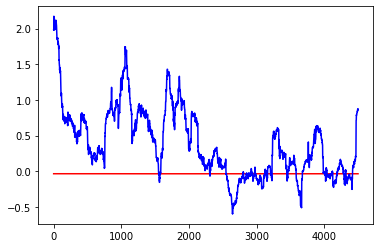

In [29]:
plt.plot(prediction.detach().numpy(), 'r')
plt.plot(reality.detach().numpy(), 'b')